The Tri-Factor Delivery Model  

Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
print(os.getcwd())

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

C:\Users\jnlea


Load Dataset

In [53]:
df = pd.read_csv(r"C:\Users\jnlea\Desktop\Project2\Natality2016-2024expanded.csv")

print("Shape:", df.shape)
df.head()

Shape: (105, 6)


,Notes,Source of Payment for Delivery Expanded,Source of Payment for Delivery Expanded Code,Delivery Method Expanded,Delivery Method Expanded Code,Births
0,NaN,Medicaid,1.0,Vaginal (excludes vaginal after previous C-sec...,1.0,2110481.0
1,NaN,Medicaid,1.0,Vaginal after previous c-section,2.0,73473.0
2,NaN,Medicaid,1.0,Primary C-section,3.0,545113.0
3,NaN,Medicaid,1.0,Repeat C-section,4.0,472556.0
4,NaN,Medicaid,1.0,Vaginal (unknown if previous c-section),5.0,3241.0


Auto-detect Columns

In [55]:
def find_col(df, contains_all):
    """Find first column whose name contains ALL substrings (case-insensitive)."""
    cols = list(df.columns)
    for c in cols:
        c_low = c.lower()
        if all(s.lower() in c_low for s in contains_all):
            return c
    return None

payer_col = find_col(df, ["payment"]) or find_col(df, ["source", "payment"])
delivery_col = find_col(df, ["delivery", "method"])
births_col = find_col(df, ["births"])

print("Detected payer col   :", payer_col)
print("Detected delivery col :", delivery_col)
print("Detected births col   :", births_col)

if not all([payer_col, delivery_col, births_col]):
    raise ValueError("Could not auto-detect one or more required columns. Print df.columns and rename accordingly.")


Detected payer col   : Source of Payment for Delivery Expanded
Detected delivery col : Delivery Method Expanded
Detected births col   : Births


Data Cleaning

In [57]:
work = df[[payer_col, delivery_col, births_col]].copy()
work = work.dropna(subset=[payer_col, delivery_col, births_col])

work[births_col] = pd.to_numeric(work[births_col], errors="coerce")
work = work.dropna(subset=[births_col])

work[payer_col] = work[payer_col].astype(str).str.strip()
work[delivery_col] = work[delivery_col].astype(str).str.strip()

print("Cleaned shape:", work.shape)
work.head()


Cleaned shape: (61, 3)


,Source of Payment for Delivery Expanded,Delivery Method Expanded,Births
0,Medicaid,Vaginal (excludes vaginal after previous C-sec...,2110481.0
1,Medicaid,Vaginal after previous c-section,73473.0
2,Medicaid,Primary C-section,545113.0
3,Medicaid,Repeat C-section,472556.0
4,Medicaid,Vaginal (unknown if previous c-section),3241.0


Classify Delivery Type

In [59]:
def classify_delivery(method):
    m = str(method)
    if "Vaginal" in m:
        return "Vaginal"
    if "C-section" in m or "Cesarean" in m or "Cesarian" in m:
        return "C-section"
    return "Unknown"

def classify_cs_subtype(method):
    m = str(method)
    if "Primary C-section" in m:
        return "Primary"
    if "Repeat C-section" in m:
        return "Repeat"
    if "C-section" in m or "Cesarean" in m:
        return "C-section (unspecified)"
    return None

work["Delivery_Group"] = work[delivery_col].apply(classify_delivery)
work["CS_Subtype"] = work[delivery_col].apply(classify_cs_subtype)

work["Delivery_Group"].value_counts(dropna=False)


Delivery_Group
Vaginal      27
C-section    26
Unknown       8
Name: count, dtype: int64

Compute C-Section Rate by Payer

In [61]:
agg = work.groupby([payer_col, "Delivery_Group"], as_index=False)[births_col].sum()

pivot = agg.pivot(index=payer_col, columns="Delivery_Group", values=births_col).fillna(0)
for col in ["Vaginal", "C-section", "Unknown"]:
    if col not in pivot.columns:
        pivot[col] = 0

pivot["Total"] = pivot["Vaginal"] + pivot["C-section"] + pivot["Unknown"]
pivot["Csection_Rate"] = pivot["C-section"] / pivot["Total"].replace(0, np.nan)

pivot = pivot.sort_values("Csection_Rate", ascending=False)
pivot


Delivery_Group,C-section,Unknown,Vaginal,Total,Csection_Rate
Source of Payment for Delivery Expanded,,,,,
Private Insurance,1256477.0,1017.0,2521742.0,3779236.0,0.332469
Not Reported,1068430.0,2109.0,2246266.0,3316805.0,0.322126
Medicaid,1018535.0,1110.0,2187195.0,3206840.0,0.317613
"Other Government (Federal, State, Local)",23078.0,27.0,49820.0,72925.0,0.316462
Other,20931.0,38.0,46751.0,67720.0,0.309082
CHAMPUS/TRICARE,40696.0,233.0,106152.0,147081.0,0.276691
Unknown or Not Stated,15105.0,2715.0,41230.0,59050.0,0.255800
Indian Health Service,1877.0,0.0,5466.0,7343.0,0.255618
Self-Pay,56172.0,420.0,232101.0,288693.0,0.194573


Figure 1: C-Section Rate by Payer

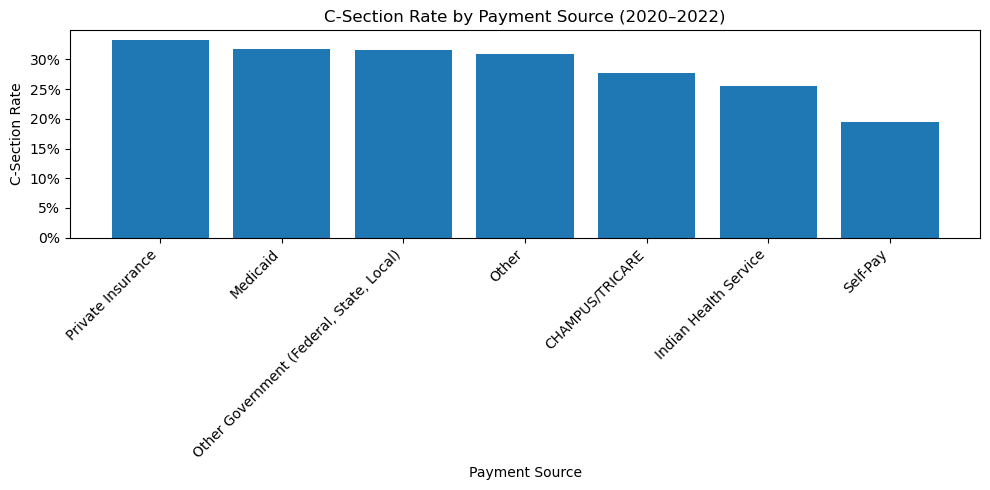

In [63]:
# Optional: drop unclear categories from the figure only
exclude = {"Unknown or Not Stated", "Not Reported"}
viz = pivot.drop(index=[x for x in pivot.index if x in exclude], errors="ignore").copy()

plt.figure(figsize=(10, 5))
plt.bar(viz.index.astype(str), viz["Csection_Rate"])
plt.title("C-Section Rate by Payment Source (2020–2022)")
plt.ylabel("C-Section Rate")
plt.xlabel("Payment Source")
plt.xticks(rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
plt.tight_layout()
plt.show()


Figure 2: Primary vs Repeat C-Sections

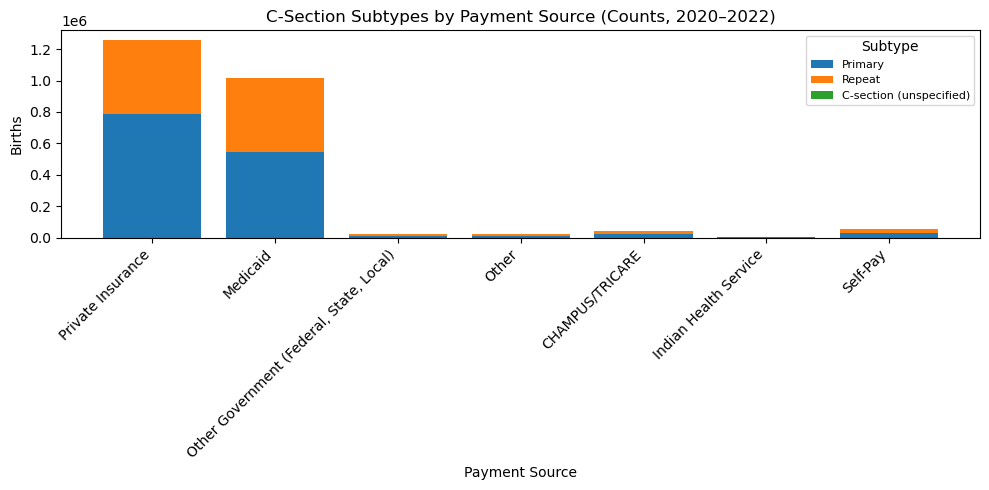

In [65]:
cs = work[work["Delivery_Group"] == "C-section"].copy()

cs_sub = cs.groupby([payer_col, "CS_Subtype"], as_index=False)[births_col].sum()
cs_piv = cs_sub.pivot(index=payer_col, columns="CS_Subtype", values=births_col).fillna(0)

for col in ["Primary", "Repeat", "C-section (unspecified)"]:
    if col not in cs_piv.columns:
        cs_piv[col] = 0

# keep the same payer ordering as viz (if possible)
cs_piv = cs_piv.loc[cs_piv.index.intersection(viz.index)]
cs_piv = cs_piv.reindex(viz.index, fill_value=0)

plt.figure(figsize=(10, 5))
bottom = np.zeros(len(cs_piv))
for col in ["Primary", "Repeat", "C-section (unspecified)"]:
    plt.bar(cs_piv.index.astype(str), cs_piv[col].values, bottom=bottom, label=col)
    bottom += cs_piv[col].values

plt.title("C-Section Subtypes by Payment Source (Counts, 2020–2022)")
plt.ylabel("Births")
plt.xlabel("Payment Source")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Subtype", fontsize=8)
plt.tight_layout()
plt.show()


Figure 3: Delivery Composition

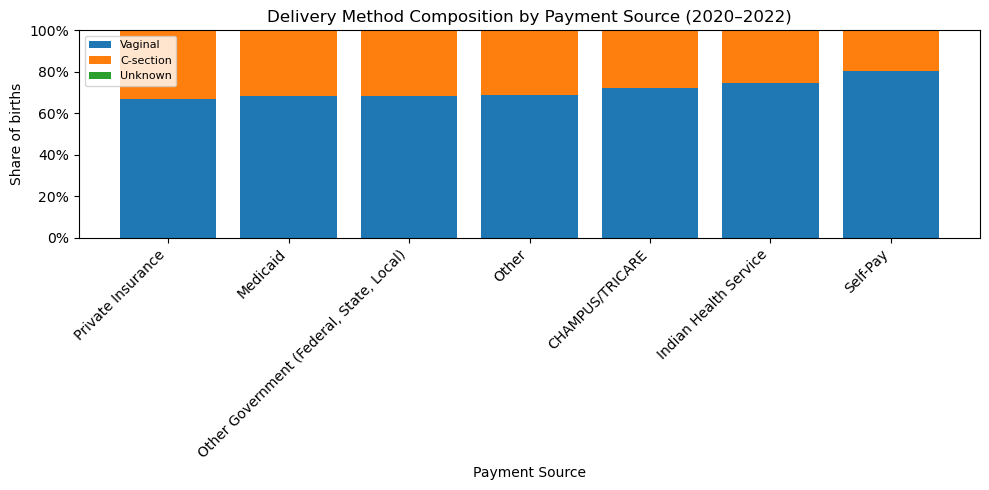

In [67]:
comp = viz[["Vaginal", "C-section", "Unknown"]].copy()
comp_pct = comp.div(comp.sum(axis=1), axis=0).fillna(0)

plt.figure(figsize=(10, 5))
bottom = np.zeros(len(comp_pct))
for col in ["Vaginal", "C-section", "Unknown"]:
    plt.bar(comp_pct.index.astype(str), comp_pct[col].values, bottom=bottom, label=col)
    bottom += comp_pct[col].values

plt.title("Delivery Method Composition by Payment Source (2020–2022)")
plt.ylabel("Share of births")
plt.xlabel("Payment Source")
plt.xticks(rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


RR (Private vs Medicaid): 1.0467   95% CI: [1.0444, 1.0489]


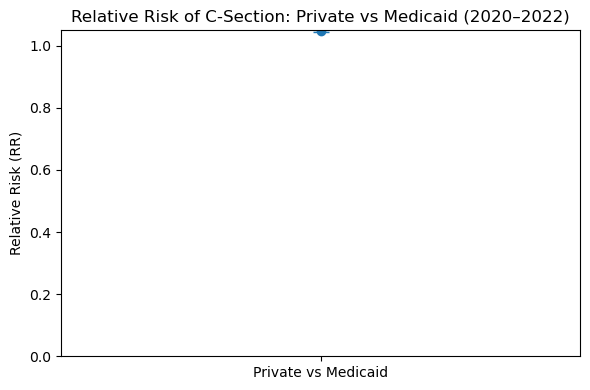

In [69]:
def rr_and_ci(cs_private, vag_private, cs_medicaid, vag_medicaid):
    p1 = cs_private / (cs_private + vag_private)
    p0 = cs_medicaid / (cs_medicaid + vag_medicaid)
    rr = p1 / p0

    # log(RR) standard error approximation for 2x2 table
    se = np.sqrt((1/cs_private) - (1/(cs_private+vag_private)) + (1/cs_medicaid) - (1/(cs_medicaid+vag_medicaid)))
    lo = np.exp(np.log(rr) - 1.96 * se)
    hi = np.exp(np.log(rr) + 1.96 * se)
    return rr, lo, hi

# Pull counts from pivot (includes Unknown in Total, so we use Vaginal + C-section only here)
if ("Private Insurance" in pivot.index) and ("Medicaid" in pivot.index):
    cs_priv = pivot.loc["Private Insurance", "C-section"]
    vag_priv = pivot.loc["Private Insurance", "Vaginal"]
    cs_med  = pivot.loc["Medicaid", "C-section"]
    vag_med = pivot.loc["Medicaid", "Vaginal"]

    rr, lo, hi = rr_and_ci(cs_priv, vag_priv, cs_med, vag_med)

    print(f"RR (Private vs Medicaid): {rr:.4f}   95% CI: [{lo:.4f}, {hi:.4f}]")

    plt.figure(figsize=(6, 4))
    plt.errorbar(["Private vs Medicaid"], [rr], yerr=[[rr-lo], [hi-rr]], fmt="o", capsize=6)
    plt.title("Relative Risk of C-Section: Private vs Medicaid (2020–2022)")
    plt.ylabel("Relative Risk (RR)")
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()
else:
    print("Could not find 'Private Insurance' and/or 'Medicaid' exactly. Print pivot.index to see payer names.")
    print(pivot.index.tolist())


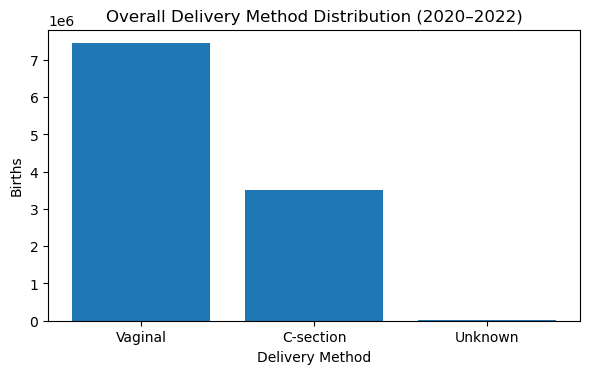

Delivery_Group
Vaginal      7436723.0
C-section    3501301.0
Unknown         7669.0
Name: Births, dtype: float64

In [71]:
overall = work.groupby("Delivery_Group")[births_col].sum().reindex(["Vaginal", "C-section", "Unknown"]).fillna(0)

plt.figure(figsize=(6, 4))
plt.bar(overall.index.astype(str), overall.values)
plt.title("Overall Delivery Method Distribution (2020–2022)")
plt.ylabel("Births")
plt.xlabel("Delivery Method")
plt.tight_layout()
plt.show()

overall
